To previous notebook: [Credit Card EDA](./credit-card-eda.ipynb)<br/>
To the README: [README](./README.md)<br/>

--------------------------------------------------------------------------------

In [1]:
# Import base packages
from sklearn.model_selection import GridSearchCV
from pipe import select, where, sort

import utils.style as style
from utils.confusion import confusion_matrix
from utils.credit_card import File, Col
from utils.evaluation import evaluate_model, evaluate_hpt, compare_models

# Credit Card Fraud: Machine Learning

In this notebook we will take the results and preparations from the EDA part and train and compare a selection of different models to build one compound that hopefully is going to be able to detect frauds reliably.

For comparing the models, we will use the $F_\beta$ score.
It's similar to the $F_1$ score in terms of evaluating false predictions, but the $\beta$ parameter allows us to put higher weight on either the false positives or false negatives.
This is due to the fact that a false negative prediction, that is, a fraud that falsely gets classified as genuine, has much more dire consequences than a genuine transaction that gets classified as fraud, which will usually only cause some inconveniences for one customer.
Nevertheless, for the final model, we *are* interested in also keeping the false positives as low as possible.

## Setup: Score and Best Model Tracking

As previously mentioned, our score will be the $F_beta$ score. We are free to choose our $\beta$ as we like, with $\beta > 1$ resulting in lower scores for more false negatives and $\beta < 1$ resulting in the opposite.
We pick $\beta = 10$.
A different choice might result in different best parameters during the hyperparameter tuning process and *could* lead to a different best model over the course of testing different models, but in a test run we found essentially the same outcome for other values for $\beta$.

In [2]:
# Fix beta and scorer
from sklearn.metrics import fbeta_score, make_scorer

BETA = 10.0
AVERAGE = 'binary'
scorer = make_scorer(fbeta_score, beta=BETA, average=AVERAGE)

During our tests, we will keep track of the best model and its best score with a simple list and functions to add and extract information in a convenient way:

In [201]:
MODELS = []

def add_model(name, results, on_scaled):
    global MODELS
    MODELS.append((results.fbeta, name, results, on_scaled))

def add_unscaled_model(name, results): add_model(name, results, False)
def add_scaled_model(name, results): add_model(name, results, True)

def score(record): return record[0]
def name(record): return record[1]
def results(record): return record[2]
def is_trained_on_scaled(record): return record[3]
def top(n, on_scaled):
    global MODELS
    return list(
        MODELS | where(lambda model: is_trained_on_scaled(model)==on_scaled)
               | sort(key=score, reverse=True)
    )[:n]
    return sorted(MODELS, reverse=True)[:n]
def top_unscaled(n): return top(n, False)
def top_scaled(n): return top(n, True)
def top_overall(n):
    global MODELS
    return list(sorted(MODELS, key=score, reverse=True))[:n]

# To see improvements across the models:
BEST_MODEL, BEST_SCORE = None, None
# To compare different candidates through their tuning stage:
BEST_HPT_RESULT, BEST_SCALED_HPT_RESULT, BEST_HPT_15_RESULT, BEST_SCALED_HPT_15_RESULT = None, None, None, None

## Setup: Loading the Training and Testing Data

We set up our data in the previous notebook and just need to read in the files.
However, we were discussing whether or not scaling the data was a good idea.
And we decided to keep separate versions of the data frames in order to compare the results from both.

In [4]:
# Regular Training Data
data_train = File.load(File.training_undersampled)
X_train = data_train.drop(Col.target, axis=1)
y_train = data_train[Col.target]

# Regular Verification Data
data_verification = File.load(File.verification)
X_test = data_verification.drop(Col.target, axis=1)
y_true = data_verification[Col.target]

In [5]:
# Scaled Training Data
data_train_scaled = File.load(File.training_undersampled_scaled)
X_train_scaled = data_train_scaled.drop(Col.target, axis=1)

# Scaled Verification Data
data_verification_scaled = File.load(File.verification_scaled)
X_test_scaled = data_verification_scaled.drop(Col.target, axis=1)

But we also wanted to train our prototypes on just a subset of the features to improve their computational performance.
So, out of the 30 available features, let's focus on the top 15 for that:

In [6]:
features = Col.top(15)['Feature']
features

0     V $17$
1     V $14$
2     V $12$
3     V $10$
4     V $16$
5      V $3$
6      V $7$
7     V $11$
8      V $4$
9     V $18$
10     V $1$
11     V $9$
12     V $5$
13     V $2$
14     V $6$
Name: Feature, dtype: object

In [7]:
# Create training and verification subsets with those selected features:
X_train_15 = X_train[features].copy()
X_test_15 = X_test[features].copy()
X_train_scaled_15 = X_train_scaled[features].copy()
X_test_scaled_15 = X_test_scaled[features].copy()

--------------------------------------------------------------------------------

## Random Forest

Our first candidate is the random forest classification model.

In [8]:
from sklearn.ensemble import RandomForestClassifier

In [9]:
random_forest = RandomForestClassifier(n_jobs=-1, random_state=404)     # base estimator
rf_param_grid = {                                                       # parameter grid for hyperparameter tuning
    'n_estimators': [5, 10, 20, 100, 150],
    'max_depth':    [5, 10, 20, 40, 60, None],
    'criterion':    ['gini', 'entropy', 'log_loss'],
}

In [10]:
rf_model = GridSearchCV(
    estimator=random_forest,
    param_grid=rf_param_grid,
    refit=True,
    verbose=0,
    scoring=scorer
)
%time _ = rf_model.fit(X_train_15, y_train)

CPU times: user 1min 11s, sys: 12.3 s, total: 1min 23s
Wall time: 36 s


In [11]:
# Evaluate the process
rf_hpt_result = evaluate_hpt(
    model=rf_model,
    X_test=X_test_15,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE
)
BEST_HPT_15_RESULT = rf_hpt_result

-- Training Results --
Best Parameters:
	criterion:	gini
	max_depth:	20
	n_estimators:	5
Best Score:
	0.866031

-- Testing Results --
Accuracy    on Verification Data:	0.986325
Fbeta scroe on Verification Data:	0.829388

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56651
           1       0.10      0.89      0.18        95

    accuracy                           0.99     56746
   macro avg       0.55      0.94      0.59     56746
weighted avg       1.00      0.99      0.99     56746

False negatives: 10 (10.526% out of 95 true positives, 0.018% overall)



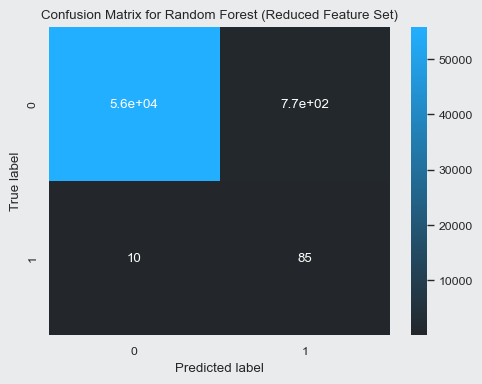

In [12]:
# Display the confusion matrix
confusion_matrix(y_true, rf_hpt_result.predictions, 'Random Forest (Reduced Feature Set)')

Next, let's let the best candidate of this process train on the full featureset.

In [13]:
best_random_forest = rf_model.best_estimator_
%time _ = best_random_forest.fit(X_train, y_train)

CPU times: user 217 ms, sys: 102 ms, total: 320 ms
Wall time: 42.9 ms


In [14]:
# Evaluate this model
rf_model_result = evaluate_model(
    model=best_random_forest,
    X_test=X_test,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE
)
BEST_HPT_RESULT = rf_model_result


-- Testing Results --
Accuracy    on Verification Data:	0.984774
Fbeta scroe on Verification Data:	0.822397

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56651
           1       0.09      0.89      0.16        95

    accuracy                           0.98     56746
   macro avg       0.55      0.94      0.58     56746
weighted avg       1.00      0.98      0.99     56746

False negatives: 10 (10.526% out of 95 true positives, 0.018% overall)



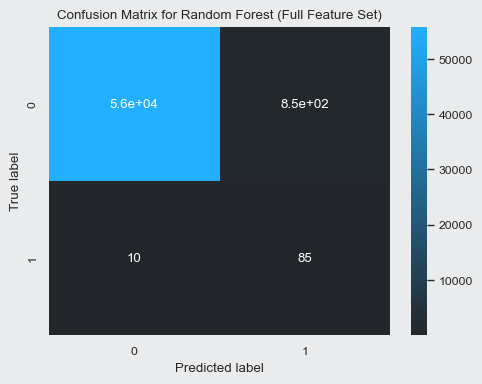

In [15]:
# Display the confusion matrix
confusion_matrix(y_true, rf_model_result.predictions, "Random Forest (Full Feature Set)")

In [16]:
# Check on learning progress when seeing the full feature set
_ = compare_models(rf_model_result, rf_hpt_result)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.006992 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.001551 --> Worsened!

Best model so far:
RandomForestClassifier(max_depth=20, n_estimators=5, n_jobs=-1,
                       random_state=404)
Its score: 0.829388


The model was able to improve its overall scores a little bit; this is a good start.

We add this model to our list of best results before repeating the process with the scaled featues.

In [202]:
# Store the model results
add_unscaled_model("Random Forest", rf_model_result)

# Keep track of the best model so far
BEST_MODEL, BEST_SCORE = compare_models(rf_model_result, results(top_overall(1)[0]))

-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.000000 --> Worsened!
new_results.accuracy - old_results.accuracy = 0.000000 --> Worsened!

Best model so far:
RandomForestClassifier(max_depth=20, n_estimators=5, n_jobs=-1,
                       random_state=404)
Its score: 0.822397


In [19]:
# Repeat the process with the scaled dataset;
# Create a new grid search in order to avoid overwriting the original.
rf_scaled_model = GridSearchCV(
    estimator=random_forest,
    param_grid=rf_param_grid,
    refit=True,
    verbose=0,
    scoring=scorer
)
%time _ = rf_scaled_model.fit(X_train_scaled_15, y_train)

CPU times: user 1min 10s, sys: 11.9 s, total: 1min 22s
Wall time: 35.6 s


In [20]:
# Evaluate the process
rf_scaled_hpt_result = evaluate_hpt(
    model=rf_scaled_model,
    X_test=X_test_scaled_15,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE
)

-- Training Results --
Best Parameters:
	criterion:	gini
	max_depth:	20
	n_estimators:	5
Best Score:
	0.866031

-- Testing Results --
Accuracy    on Verification Data:	0.986325
Fbeta scroe on Verification Data:	0.829388

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56651
           1       0.10      0.89      0.18        95

    accuracy                           0.99     56746
   macro avg       0.55      0.94      0.59     56746
weighted avg       1.00      0.99      0.99     56746

False negatives: 10 (10.526% out of 95 true positives, 0.018% overall)



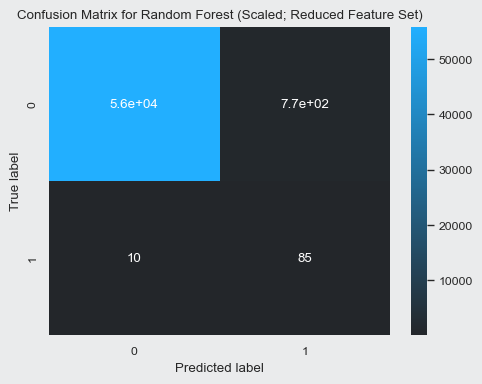

In [21]:
# Display the confusion matrix
confusion_matrix(y_true, rf_scaled_hpt_result.predictions, "Random Forest (Scaled; Reduced Feature Set)")

Again, let's let the best one learn from the full featureset.

In [22]:
best_random_forest_scaled = rf_scaled_model.best_estimator_
%time _ = best_random_forest_scaled.fit(X_train_scaled, y_train)

CPU times: user 67.6 ms, sys: 5.02 ms, total: 72.7 ms
Wall time: 17.1 ms


In [23]:
# Evaluate this model
rf_scaled_model_result = evaluate_model(
    model=best_random_forest_scaled,
    X_test=X_test_scaled,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE
)


-- Testing Results --
Accuracy    on Verification Data:	0.984774
Fbeta scroe on Verification Data:	0.822397

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56651
           1       0.09      0.89      0.16        95

    accuracy                           0.98     56746
   macro avg       0.55      0.94      0.58     56746
weighted avg       1.00      0.98      0.99     56746

False negatives: 10 (10.526% out of 95 true positives, 0.018% overall)



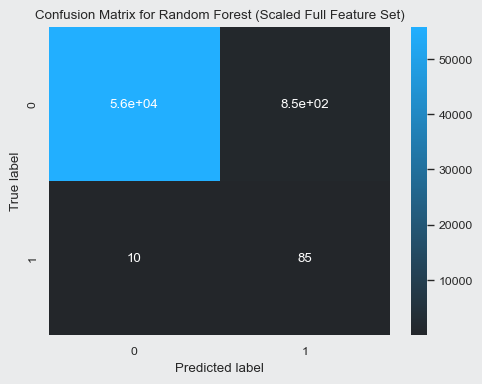

In [24]:
# Display the confusion matrix
confusion_matrix(y_true, rf_scaled_model_result.predictions, "Random Forest (Scaled Full Feature Set)")

In [203]:
add_scaled_model("Random Forest", rf_scaled_model_result)
BEST_SCALED_HPT_15_RESULT = BEST_HPT_15_RESULT
BEST_SCALED_HPT_RESULT = BEST_HPT_RESULT

It turns out that the results are practically the same.
However, the random forest model itself isn't one of those that benefit from scaling in the first place.

--------------------------------------------------------------------------------

## K Nearest Neighbors

Our next candidate is KNN.
This model significantly benefits from our undersampling approach, as its computation time drastically increases with the data complexity.
The process we follow is the exact same as for the random forest approach:

In [26]:
from sklearn.neighbors import KNeighborsClassifier

In [27]:
knn = KNeighborsClassifier(n_jobs=-1)                                   # base estimator
knn_param_grid = {                                                      # parameter grid for hyperparameter tuning
    'n_neighbors':  [5, 10, 20, 100, 150],
    'weights':      ['uniform', 'distance'],
}

In [28]:
knn_model = GridSearchCV(
    estimator=knn,
    param_grid=knn_param_grid,
    refit=True,
    verbose=0,
    scoring=scorer
)
%time _ = knn_model.fit(X_train_15, y_train)

CPU times: user 1.4 s, sys: 99.8 ms, total: 1.5 s
Wall time: 992 ms


In [29]:
# Evaluate the process
knn_hpt_result = evaluate_hpt(
    model=knn_model,
    X_test=X_test_15,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE
)

-- Training Results --
Best Parameters:
	n_neighbors:	5
	weights:	uniform
Best Score:
	0.866154

-- Testing Results --
Accuracy    on Verification Data:	0.995207
Fbeta scroe on Verification Data:	0.871839

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.24      0.89      0.38        95

    accuracy                           1.00     56746
   macro avg       0.62      0.95      0.69     56746
weighted avg       1.00      1.00      1.00     56746

False negatives: 10 (10.526% out of 95 true positives, 0.018% overall)



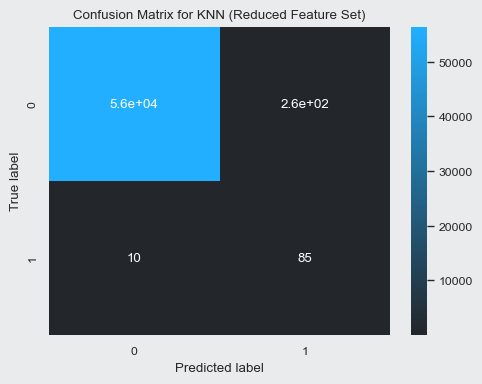

In [30]:
# Display the confusion matrix
confusion_matrix(y_true, knn_hpt_result.predictions, "KNN (Reduced Feature Set)")

In [31]:
# Compare HPT processes
_ = compare_models(knn_hpt_result, BEST_HPT_15_RESULT)

-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = 0.042451 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.008882 --> Improvement!

Best model so far:
KNeighborsClassifier(n_jobs=-1) with Parameters
{'n_neighbors': 5, 'weights': 'uniform'}
Its score: 0.871839


In [32]:
BEST_HPT_15_RESULT = knn_hpt_result

So KNN's hyperparameter tuning results score higher than random forest's on the training data subset with the selected features.
Note that the score here refers to the training score, not the verification one.

In the end, however, we are interested in the best model's capabilities on the full feature set.
So first, let's see whether KNN was improved by introducing it to the same:

In [33]:
best_knn = knn_model.best_estimator_
%time _ = best_knn.fit(X_train, y_train)

CPU times: user 4.53 ms, sys: 701 μs, total: 5.23 ms
Wall time: 1.45 ms


In [34]:
# Evaluate this model
knn_model_result = evaluate_model(
    model=best_knn,
    X_test=X_test,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE
)


-- Testing Results --
Accuracy    on Verification Data:	0.988968
Fbeta scroe on Verification Data:	0.655909

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56651
           1       0.10      0.69      0.17        95

    accuracy                           0.99     56746
   macro avg       0.55      0.84      0.58     56746
weighted avg       1.00      0.99      0.99     56746

False negatives: 29 (30.526% out of 95 true positives, 0.051% overall)



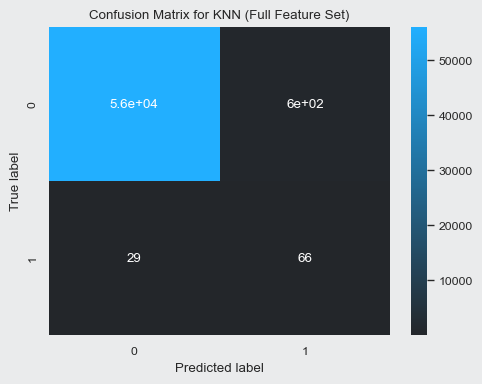

In [35]:
# Display the confusion matrix
confusion_matrix(y_true, knn_model_result.predictions, "KNN (Full Feature Set)")

In [36]:
_ = compare_models(knn_model_result, BEST_HPT_RESULT)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.166488 --> Worsened!
new_results.accuracy - old_results.accuracy = 0.004194 --> Improvement!

Best model so far:
RandomForestClassifier(max_depth=20, n_estimators=5, n_jobs=-1,
                       random_state=404)
Its score: 0.822397


In [37]:
# Check on learning progress when seeing the full feature set
_ = compare_models(knn_model_result, knn_hpt_result)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.215930 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.006238 --> Worsened!

Best model so far:
KNeighborsClassifier(n_jobs=-1)
Its score: 0.871839


It turns out that giving KNN more features to learn from does not help increasing its score!
Or at least for the given best parameters.
This is due to the reason that KNN is extremely sensitive to the data it sees.
The introduction of new features fundamentally changes the weights and distances it would see, and thus might change the parameters for which it would perform best.

Consequently, its performance on the full feature set pales in comparison to random forest, even though it did a better job on the reduced one.

However, KNN is known to perform better on scaled data; let's store our results just as we did before and check its abilities on the other dataset.

In [204]:
# Store the model results
add_unscaled_model("K Nearest Neighbours", knn_model_result)

BEST_MODEL, BEST_SCORE = compare_models(knn_model_result, results(top_overall(1)[0]))

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.166488 --> Worsened!
new_results.accuracy - old_results.accuracy = 0.004194 --> Improvement!

Best model so far:
RandomForestClassifier(max_depth=20, n_estimators=5, n_jobs=-1,
                       random_state=404)
Its score: 0.822397


In [39]:
# Repeat the process with the scaled dataset;
# Create a new grid search in order to avoid overwriting the original.
knn_scaled_model = GridSearchCV(
    estimator=knn,
    param_grid=knn_param_grid,
    refit=True,
    verbose=0,
    scoring=scorer
)
%time _ = knn_scaled_model.fit(X_train_scaled_15, y_train)

CPU times: user 1.44 s, sys: 98 ms, total: 1.54 s
Wall time: 987 ms


In [40]:
# Evaluate the process
knn_scaled_hpt_result = evaluate_hpt(
    model=knn_scaled_model,
    X_test=X_test_scaled_15,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE
)

-- Training Results --
Best Parameters:
	n_neighbors:	5
	weights:	distance
Best Score:
	0.863548

-- Testing Results --
Accuracy    on Verification Data:	0.994484
Fbeta scroe on Verification Data:	0.868224

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56651
           1       0.22      0.89      0.35        95

    accuracy                           0.99     56746
   macro avg       0.61      0.94      0.67     56746
weighted avg       1.00      0.99      1.00     56746

False negatives: 10 (10.526% out of 95 true positives, 0.018% overall)



In [41]:
_ = compare_models(knn_scaled_hpt_result, BEST_SCALED_HPT_15_RESULT)

-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = 0.038836 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.008159 --> Improvement!

Best model so far:
KNeighborsClassifier(n_jobs=-1, weights='distance') with Parameters
{'n_neighbors': 5, 'weights': 'distance'}
Its score: 0.868224


In [42]:
BEST_SCALED_HPT_15_RESULT = knn_scaled_hpt_result

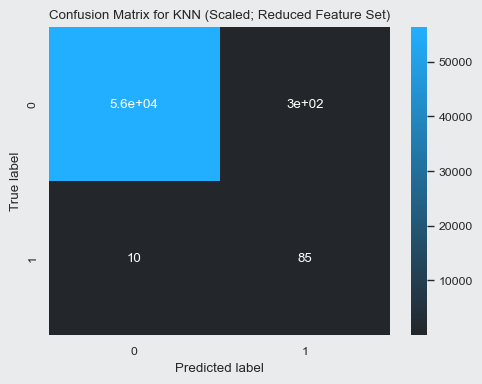

In [43]:
# Display the confusion matrix
confusion_matrix(y_true, knn_scaled_hpt_result.predictions, "KNN (Scaled; Reduced Feature Set)")

Again, let's let the best one learn from the full featureset.

In [44]:
best_knn_scaled = knn_scaled_model.best_estimator_
%time _ = best_knn_scaled.fit(X_train_scaled, y_train)

CPU times: user 4.02 ms, sys: 753 μs, total: 4.77 ms
Wall time: 1.3 ms


In [45]:
# Evaluate this model
knn_scaled_model_result = evaluate_model(
    model=best_knn_scaled,
    X_test=X_test_scaled,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE
)


-- Testing Results --
Accuracy    on Verification Data:	0.993867
Fbeta scroe on Verification Data:	0.865162

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56651
           1       0.20      0.89      0.33        95

    accuracy                           0.99     56746
   macro avg       0.60      0.94      0.66     56746
weighted avg       1.00      0.99      1.00     56746

False negatives: 10 (10.526% out of 95 true positives, 0.018% overall)



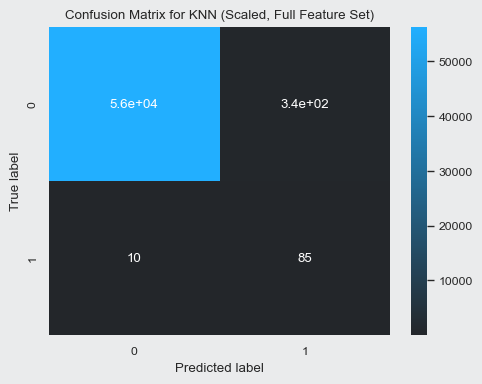

In [46]:
# Display the confusion matrix
confusion_matrix(y_true, knn_scaled_model_result.predictions, "KNN (Scaled, Full Feature Set)")

In [47]:
_ = compare_models(knn_scaled_model_result, BEST_SCALED_HPT_RESULT)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.042765 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.009093 --> Improvement!

Best model so far:
KNeighborsClassifier(n_jobs=-1, weights='distance')
Its score: 0.865162


In [48]:
BEST_SCALED_HPT_RESULT = knn_scaled_model_result

In [49]:
# Check on learning progress when seeing the full feature set
_ = compare_models(knn_scaled_model_result, knn_scaled_hpt_result)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.003062 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.000617 --> Worsened!

Best model so far:
KNeighborsClassifier(n_jobs=-1, weights='distance')
Its score: 0.868224


Again, KNN doesn't perform as good on the full feature set as it did on the reduced one, but the difference in the score is way lower now!

Now, looking at the best models on the full and scaled feature set, we see a difference to the unscaled version:

In [205]:
BEST_MODEL, BEST_SCORE = compare_models(knn_scaled_model_result, results(top_overall(1)[0]))

-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.042765 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.009093 --> Improvement!

Best model so far:
KNeighborsClassifier(n_jobs=-1, weights='distance')
Its score: 0.865162


This time KNN *does* beat random forest!
In fact, looking at the confusion matrices, while KNN has the same amount of false negatives to show, its false positive predictions look way better than random forest's!
(Which is why the $F_{10}$ score is better here.)

We will add this candidate to our best models as well, with a reminder that it needs the scaled dataset to perform optimally.

In [206]:
add_scaled_model("K Nearest Neighbours", knn_scaled_model_result)

--------------------------------------------------------------------------------

## Naive Bayes

Our next candidate is Naive Bayes.
Now this model doesn't offer much in terms of hyperparameter tuning, but we want to include it anyways.

Again, the same procedure as before...

In [52]:
from sklearn.naive_bayes import GaussianNB

In [53]:
naive_bayes = GaussianNB()                                             # base estimator
rel_positive = y_true.value_counts(True)[1]
nb_param_grid = {                                                      # parameter grid for hyperparameter tuning
    'priors': [None, [1 - rel_positive, rel_positive]],
}

In [54]:
nb_model = GridSearchCV(
    estimator=naive_bayes,
    param_grid=nb_param_grid,
    refit=True,
    verbose=0,
    scoring=scorer
)
%time _ = nb_model.fit(X_train_15, y_train)

CPU times: user 40.7 ms, sys: 4.06 ms, total: 44.8 ms
Wall time: 45.2 ms


In [55]:
# Evaluate the process
nb_hpt_result = evaluate_hpt(
    model=nb_model,
    X_test=X_test_15,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE
)

-- Training Results --
Best Parameters:
	priors:	None
Best Score:
	0.847240

-- Testing Results --
Accuracy    on Verification Data:	0.982078
Fbeta scroe on Verification Data:	0.791745

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56651
           1       0.08      0.87      0.14        95

    accuracy                           0.98     56746
   macro avg       0.54      0.93      0.57     56746
weighted avg       1.00      0.98      0.99     56746

False negatives: 12 (12.632% out of 95 true positives, 0.021% overall)



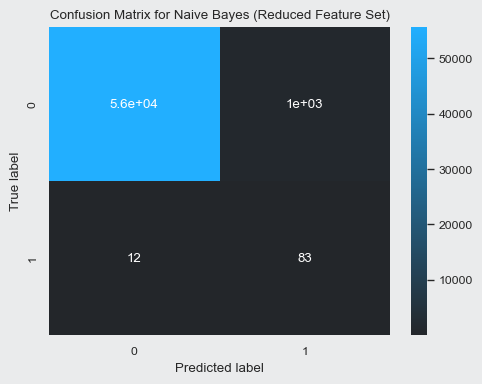

In [56]:
# Display the confusion matrix
confusion_matrix(y_true, nb_hpt_result.predictions, "Naive Bayes (Reduced Feature Set)")

In [57]:
# Compare HPT processes
_ = compare_models(nb_hpt_result, BEST_HPT_15_RESULT)

-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = -0.080094 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.013129 --> Worsened!

Best model so far:
KNeighborsClassifier(n_jobs=-1) with Parameters
{'n_neighbors': 5, 'weights': 'uniform'}
Its score: 0.871839


In [58]:
BEST_HPT_15_RESULT = nb_hpt_result

Naive Bayes now scores a little bit higher in the hyperparameter tuning process than random forest (on the unscaled dataset).
It shows a few more false negatives here, but significantly less false positives.

The picture changes, however, if we compare them on the full feature set.
First, let's evaluate its learning progress when seeing the full data:

In [59]:
best_nb = nb_model.best_estimator_
%time _ = best_nb.fit(X_train, y_train)

CPU times: user 3.82 ms, sys: 2.29 ms, total: 6.12 ms
Wall time: 4.72 ms


In [60]:
# Evaluate this model
nb_model_result = evaluate_model(
    model=best_nb,
    X_test=X_test,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE
)


-- Testing Results --
Accuracy    on Verification Data:	0.969936
Fbeta scroe on Verification Data:	0.743371

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     56651
           1       0.05      0.87      0.09        95

    accuracy                           0.97     56746
   macro avg       0.52      0.92      0.54     56746
weighted avg       1.00      0.97      0.98     56746

False negatives: 12 (12.632% out of 95 true positives, 0.021% overall)



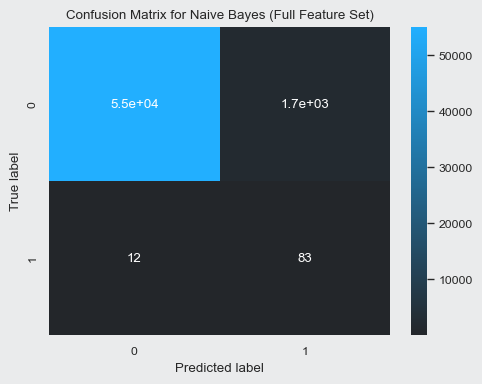

In [61]:
# Display the confusion matrix
confusion_matrix(y_true, nb_model_result.predictions, "Naive Bayes (Full Feature Set)")

In [62]:
# Check on learning progress when seeing the full feature set
_ = compare_models(nb_model_result, nb_hpt_result)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.048374 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.012142 --> Worsened!

Best model so far:
GaussianNB()
Its score: 0.791745


Again, we see a case where giving the model the full feature set acutally gets it more confused.

Thus you can see a clear difference between those results and the ones from random forest:

In [63]:
# Compare NB and best model on full feature set:
_ = compare_models(nb_model_result, BEST_HPT_RESULT)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.079025 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.014838 --> Worsened!

Best model so far:
RandomForestClassifier(max_depth=20, n_estimators=5, n_jobs=-1,
                       random_state=404)
Its score: 0.822397


Here, random forest keeps the upper ground.

Anyways, let's store this model for later and move on with the scaled dataset.

In [207]:
# Store the model results
add_unscaled_model("Naive Bayes", nb_model_result)

BEST_MODEL, BEST_SCORE = compare_models(nb_model_result, results(top_overall(1)[0]))

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.121790 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.023931 --> Worsened!

Best model so far:
KNeighborsClassifier(n_jobs=-1, weights='distance')
Its score: 0.865162


In [65]:
# Repeat the process with the scaled dataset;
# Create a new grid search in order to avoid overwriting the original.
nb_scaled_model = GridSearchCV(
    estimator=naive_bayes,
    param_grid=nb_param_grid,
    refit=True,
    verbose=0,
    scoring=scorer
)
%time _ = nb_scaled_model.fit(X_train_scaled_15, y_train)

CPU times: user 39.5 ms, sys: 3.43 ms, total: 43 ms
Wall time: 42.9 ms


In [66]:
# Evaluate the process
nb_scaled_hpt_result = evaluate_hpt(
    model=nb_scaled_model,
    X_test=X_test_scaled_15,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE
)

-- Training Results --
Best Parameters:
	priors:	None
Best Score:
	0.847240

-- Testing Results --
Accuracy    on Verification Data:	0.982078
Fbeta scroe on Verification Data:	0.791745

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56651
           1       0.08      0.87      0.14        95

    accuracy                           0.98     56746
   macro avg       0.54      0.93      0.57     56746
weighted avg       1.00      0.98      0.99     56746

False negatives: 12 (12.632% out of 95 true positives, 0.021% overall)



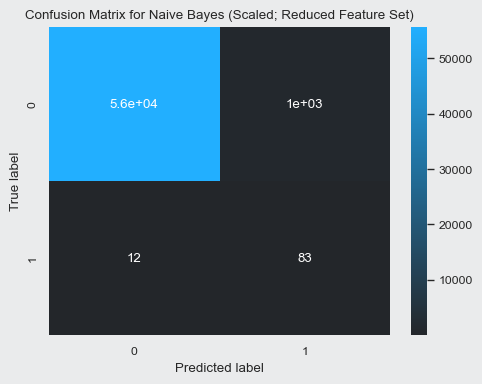

In [67]:
# Display the confusion matrix
confusion_matrix(y_true, nb_scaled_hpt_result.predictions, "Naive Bayes (Scaled; Reduced Feature Set)")

In [68]:
_ = compare_models(nb_scaled_hpt_result, BEST_SCALED_HPT_15_RESULT)

-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = -0.076479 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.012406 --> Worsened!

Best model so far:
KNeighborsClassifier(n_jobs=-1, weights='distance') with Parameters
{'n_neighbors': 5, 'weights': 'distance'}
Its score: 0.868224


Again, let's let the best one learn from the full featureset.

In [69]:
best_nb_scaled = nb_scaled_model.best_estimator_
%time _ = best_nb_scaled.fit(X_train_scaled, y_train)

CPU times: user 3.37 ms, sys: 1.79 ms, total: 5.16 ms
Wall time: 3.63 ms


In [70]:
# Evaluate this model
nb_scaled_model_result = evaluate_model(
    model=best_nb_scaled,
    X_test=X_test_scaled,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE
)


-- Testing Results --
Accuracy    on Verification Data:	0.969936
Fbeta scroe on Verification Data:	0.743371

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     56651
           1       0.05      0.87      0.09        95

    accuracy                           0.97     56746
   macro avg       0.52      0.92      0.54     56746
weighted avg       1.00      0.97      0.98     56746

False negatives: 12 (12.632% out of 95 true positives, 0.021% overall)



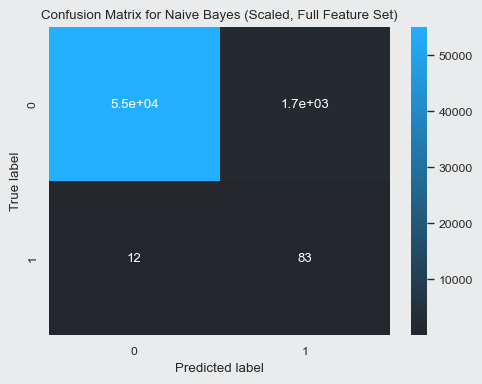

In [71]:
# Display the confusion matrix
confusion_matrix(y_true, nb_scaled_model_result.predictions, "Naive Bayes (Scaled, Full Feature Set)")

In [72]:
_ = compare_models(nb_scaled_model_result, BEST_SCALED_HPT_RESULT)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.121790 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.023931 --> Worsened!

Best model so far:
KNeighborsClassifier(n_jobs=-1, weights='distance')
Its score: 0.865162


In [73]:
# Check on learning progress when seeing the full feature set
_ = compare_models(nb_scaled_model_result, nb_scaled_hpt_result)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.048374 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.012142 --> Worsened!

Best model so far:
GaussianNB()
Its score: 0.791745


Scaled or not, naive Bayes shows the same behaviour here.

Its advantage is that it's simple, but it cannot compete with either of the other models tested so far.

In [208]:
BEST_MODEL, BEST_SCORE = compare_models(nb_scaled_model_result, results(top_overall(1)[0]))

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.121790 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.023931 --> Worsened!

Best model so far:
KNeighborsClassifier(n_jobs=-1, weights='distance')
Its score: 0.865162


We will keep track of it anyways. It might still become relevant for our combined model approach...

In [209]:
add_scaled_model("Naive Bayes", nb_scaled_model_result)

--------------------------------------------------------------------------------

## Logistic Regression

In [77]:
from sklearn.linear_model import LogisticRegression

In [78]:
logistic_regression = LogisticRegression(max_iter=15000, n_jobs=-1, random_state=404)   # base estimator
lr_param_grid = {                                                                       # parameter grid for hyperparameter tuning
    'penalty': ['l2', None],
    'tol': [1.e-4, 1.e-5, 1.e-6],
    'C': [.4+.2*n for n in range(6)],
    'fit_intercept': [True, False],
}

In [79]:
lr_model = GridSearchCV(
    estimator=logistic_regression,
    param_grid=lr_param_grid,
    refit=True,
    verbose=0,
    scoring=scorer
)

# Suppress warnings regarding 'penalty=None' in combination with C
import warnings
warnings.filterwarnings('ignore')

%time _ = lr_model.fit(X_train_15, y_train)

CPU times: user 1.13 s, sys: 176 ms, total: 1.3 s
Wall time: 9.74 s


In [80]:
# Evaluate the process
lr_hpt_result = evaluate_hpt(
    model=lr_model,
    X_test=X_test_15,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE
)

-- Training Results --
Best Parameters:
	C:	0.4
	fit_intercept:	False
	penalty:	l2
	tol:	0.0001
Best Score:
	0.958132

-- Testing Results --
Accuracy    on Verification Data:	0.684947
Fbeta scroe on Verification Data:	0.349252

              precision    recall  f1-score   support

           0       1.00      0.68      0.81     56651
           1       0.01      1.00      0.01        95

    accuracy                           0.68     56746
   macro avg       0.50      0.84      0.41     56746
weighted avg       1.00      0.68      0.81     56746

False negatives: 0 (0.000% out of 95 true positives, 0.000% overall)



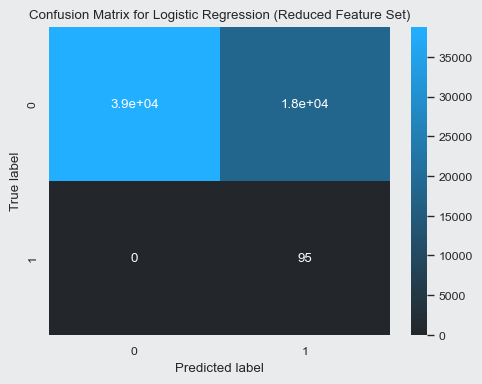

In [81]:
# Display the confusion matrix
confusion_matrix(y_true, lr_hpt_result.predictions, "Logistic Regression (Reduced Feature Set)")

In [82]:
# Compare HPT processes
_ = compare_models(lr_hpt_result, BEST_HPT_15_RESULT)

-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = -0.442493 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.297131 --> Worsened!

Best model so far:
GaussianNB() with Parameters
{'priors': None}
Its score: 0.791745


In [83]:
best_lr = lr_model.best_estimator_
%time _ = best_lr.fit(X_train, y_train)

CPU times: user 136 ms, sys: 2.91 ms, total: 139 ms
Wall time: 72.6 ms


In [84]:
# Evaluate this model
lr_model_result = evaluate_model(
    model=best_lr,
    X_test=X_test,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE
)


-- Testing Results --
Accuracy    on Verification Data:	0.984069
Fbeta scroe on Verification Data:	0.828738

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56651
           1       0.09      0.91      0.16        95

    accuracy                           0.98     56746
   macro avg       0.54      0.94      0.58     56746
weighted avg       1.00      0.98      0.99     56746

False negatives: 9 (9.474% out of 95 true positives, 0.016% overall)



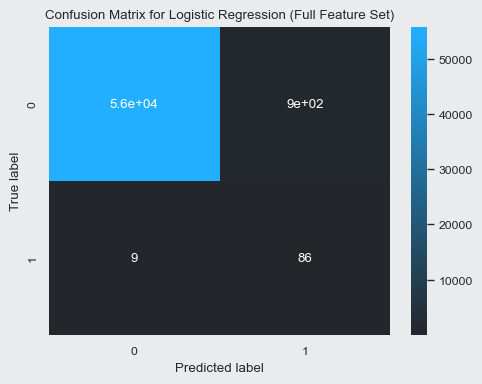

In [85]:
# Display the confusion matrix
confusion_matrix(y_true, lr_model_result.predictions, "Logistic Regression (Full Feature Set)")

In [86]:
# Check on learning progress when seeing the full feature set
_ = compare_models(lr_model_result, lr_hpt_result)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.479486 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.299122 --> Improvement!

Best model so far:
LogisticRegression(C=0.4, fit_intercept=False, max_iter=15000, n_jobs=-1,
                   random_state=404)
Its score: 0.828738


In [87]:
# Compare RF and NB on full feature set:
_ = compare_models(lr_model_result, BEST_HPT_RESULT)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.006341 --> Improvement!
new_results.accuracy - old_results.accuracy = -0.000705 --> Worsened!

Best model so far:
LogisticRegression(C=0.4, fit_intercept=False, max_iter=15000, n_jobs=-1,
                   random_state=404)
Its score: 0.828738


In [210]:
# Store the model results
add_unscaled_model("Logistic Regression", lr_model_result)

BEST_MODEL, BEST_SCORE = compare_models(lr_model_result, results(top_overall(1)[0]))

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.036424 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.009798 --> Worsened!

Best model so far:
KNeighborsClassifier(n_jobs=-1, weights='distance')
Its score: 0.865162


In [89]:
# Repeat the process with the scaled dataset;
# Create a new grid search in order to avoid overwriting the original.
lr_scaled_model = GridSearchCV(
    estimator=logistic_regression,
    param_grid=lr_param_grid,
    refit=True,
    verbose=0,
    scoring=scorer
)
%time _ = lr_scaled_model.fit(X_train_scaled_15, y_train)

CPU times: user 1.12 s, sys: 95.8 ms, total: 1.22 s
Wall time: 5.48 s


In [90]:
# Evaluate the process
lr_scaled_hpt_result = evaluate_hpt(
    model=lr_scaled_model,
    X_test=X_test_scaled_15,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE
)

-- Training Results --
Best Parameters:
	C:	0.4
	fit_intercept:	False
	penalty:	l2
	tol:	0.0001
Best Score:
	0.960035

-- Testing Results --
Accuracy    on Verification Data:	0.668364
Fbeta scroe on Verification Data:	0.337686

              precision    recall  f1-score   support

           0       1.00      0.67      0.80     56651
           1       0.01      1.00      0.01        95

    accuracy                           0.67     56746
   macro avg       0.50      0.83      0.41     56746
weighted avg       1.00      0.67      0.80     56746

False negatives: 0 (0.000% out of 95 true positives, 0.000% overall)



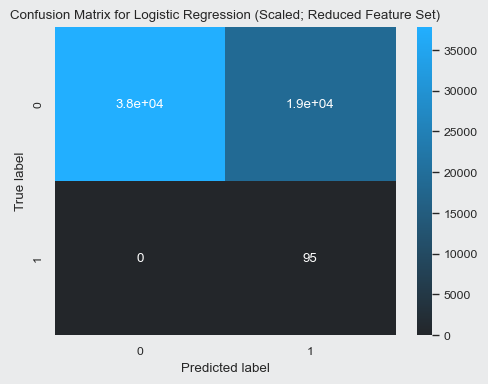

In [91]:
# Display the confusion matrix
confusion_matrix(y_true, lr_scaled_hpt_result.predictions, "Logistic Regression (Scaled; Reduced Feature Set)")

In [92]:
_ = compare_models(lr_scaled_hpt_result, BEST_SCALED_HPT_15_RESULT)

-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = -0.530538 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.326120 --> Worsened!

Best model so far:
KNeighborsClassifier(n_jobs=-1, weights='distance') with Parameters
{'n_neighbors': 5, 'weights': 'distance'}
Its score: 0.868224


In [93]:
best_lr_scaled = lr_scaled_model.best_estimator_
%time _ = best_lr_scaled.fit(X_train_scaled, y_train)

CPU times: user 204 ms, sys: 22.2 ms, total: 226 ms
Wall time: 48.2 ms


In [94]:
# Evaluate this model
lr_scaled_model_result = evaluate_model(
    model=best_lr_scaled,
    X_test=X_test_scaled,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE
)


-- Testing Results --
Accuracy    on Verification Data:	0.827283
Fbeta scroe on Verification Data:	0.474056

              precision    recall  f1-score   support

           0       1.00      0.83      0.91     56651
           1       0.01      0.96      0.02        95

    accuracy                           0.83     56746
   macro avg       0.50      0.89      0.46     56746
weighted avg       1.00      0.83      0.90     56746

False negatives: 4 (4.211% out of 95 true positives, 0.007% overall)



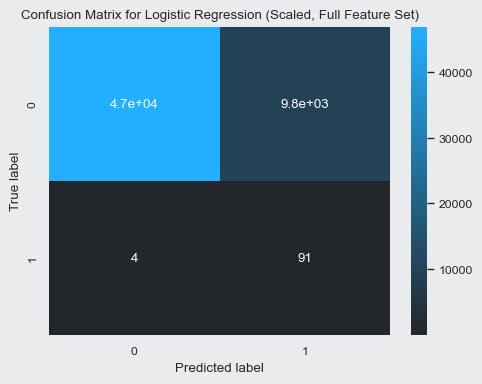

In [95]:
# Display the confusion matrix
confusion_matrix(y_true, lr_scaled_model_result.predictions, "Logistic Regression (Scaled, Full Feature Set)")

In [96]:
_ = compare_models(lr_scaled_model_result, BEST_SCALED_HPT_RESULT)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.391106 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.166584 --> Worsened!

Best model so far:
KNeighborsClassifier(n_jobs=-1, weights='distance')
Its score: 0.865162


In [97]:
# Check on learning progress when seeing the full feature set
_ = compare_models(lr_scaled_model_result, lr_scaled_hpt_result)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.136370 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.158919 --> Improvement!

Best model so far:
LogisticRegression(C=0.4, fit_intercept=False, max_iter=15000, n_jobs=-1,
                   random_state=404)
Its score: 0.474056


In [211]:
BEST_MODEL, BEST_SCORE = compare_models(lr_scaled_model_result, results(top_overall(1)[0]))

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.391106 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.166584 --> Worsened!

Best model so far:
KNeighborsClassifier(n_jobs=-1, weights='distance')
Its score: 0.865162


In [212]:
add_scaled_model("Logistic Regression", lr_scaled_model_result)

--------------------------------------------------------------------------------

## Support Vector Machine

In [100]:
from sklearn.svm import SVC

In [101]:
svc = SVC(max_iter=15000, random_state=404)                                             # base estimator
svc_param_grid = {                                                                      # parameter grid for hyperparameter tuning
    'C': [.4+.2*n for n in range(6)],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [3, 5, 10, 15],
    'tol': [1.e-4, 1.e-5, 1.e-6],
}

In [102]:
svc_model = GridSearchCV(
    estimator=svc,
    param_grid=svc_param_grid,
    refit=True,
    verbose=0,
    scoring=scorer
)

%time _ = svc_model.fit(X_train_15, y_train)

CPU times: user 17.3 s, sys: 147 ms, total: 17.5 s
Wall time: 18 s


In [103]:
# Evaluate the process
svc_hpt_result = evaluate_hpt(
    model=svc_model,
    X_test=X_test_15,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE
)

-- Training Results --
Best Parameters:
	C:	0.4
	degree:	3
	kernel:	linear
	tol:	1e-05
Best Score:
	0.837442

-- Testing Results --
Accuracy    on Verification Data:	0.998308
Fbeta scroe on Verification Data:	0.877443

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.50      0.88      0.64        95

    accuracy                           1.00     56746
   macro avg       0.75      0.94      0.82     56746
weighted avg       1.00      1.00      1.00     56746

False negatives: 11 (11.579% out of 95 true positives, 0.019% overall)



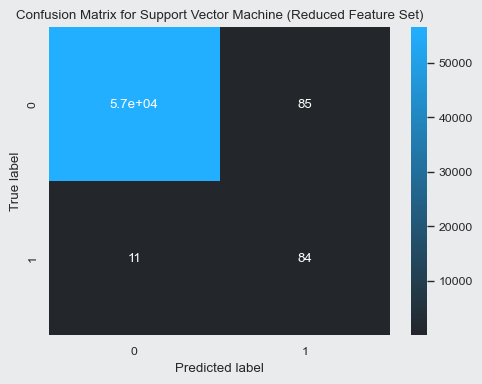

In [104]:
# Display the confusion matrix
confusion_matrix(y_true, svc_hpt_result.predictions, "Support Vector Machine (Reduced Feature Set)")

In [105]:
# Compare HPT processes
_ = compare_models(svc_hpt_result, BEST_HPT_15_RESULT)

-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = 0.085698 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.016230 --> Improvement!

Best model so far:
SVC(C=0.4, kernel='linear', max_iter=15000, random_state=404, tol=1e-05) with Parameters
{'C': 0.4, 'degree': 3, 'kernel': 'linear', 'tol': 1e-05}
Its score: 0.877443


In [106]:
best_svc = svc_model.best_estimator_
%time _ = best_svc.fit(X_train, y_train)

CPU times: user 111 ms, sys: 2.32 ms, total: 113 ms
Wall time: 39.2 ms


In [107]:
# Evaluate this model
svc_model_result = evaluate_model(
    model=best_svc,
    X_test=X_test,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE
)


-- Testing Results --
Accuracy    on Verification Data:	0.943520
Fbeta scroe on Verification Data:	0.609292

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     56651
           1       0.02      0.81      0.05        95

    accuracy                           0.94     56746
   macro avg       0.51      0.88      0.51     56746
weighted avg       1.00      0.94      0.97     56746

False negatives: 18 (18.947% out of 95 true positives, 0.032% overall)



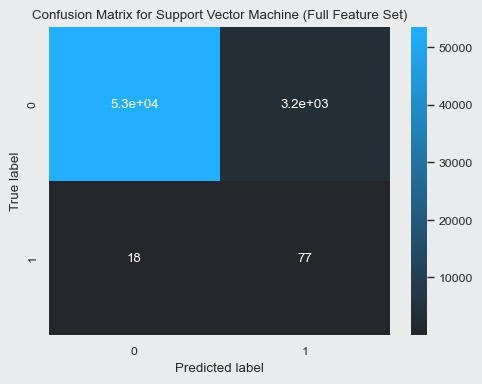

In [108]:
# Display the confusion matrix
confusion_matrix(y_true, svc_model_result.predictions, "Support Vector Machine (Full Feature Set)")

In [109]:
# Check on learning progress when seeing the full feature set
_ = compare_models(svc_model_result, svc_hpt_result)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.268152 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.054788 --> Worsened!

Best model so far:
SVC(C=0.4, kernel='linear', max_iter=15000, random_state=404, tol=1e-05)
Its score: 0.877443


In [110]:
# Compare SVC and RF on full feature set:
_ = compare_models(svc_model_result, BEST_HPT_RESULT)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.213105 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.041254 --> Worsened!

Best model so far:
RandomForestClassifier(max_depth=20, n_estimators=5, n_jobs=-1,
                       random_state=404)
Its score: 0.822397


In [213]:
# Store the model results
add_unscaled_model("Support Vector Machine", svc_model_result)

BEST_MODEL, BEST_SCORE = compare_models(svc_model_result, results(top_overall(1)[0]))

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.255870 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.050347 --> Worsened!

Best model so far:
KNeighborsClassifier(n_jobs=-1, weights='distance')
Its score: 0.865162


In [112]:
# Repeat the process with the scaled dataset;
# Create a new grid search in order to avoid overwriting the original.
svc_scaled_model = GridSearchCV(
    estimator=svc,
    param_grid=svc_param_grid,
    refit=True,
    verbose=0,
    scoring=scorer
)
%time _ = svc_scaled_model.fit(X_train_scaled_15, y_train)

CPU times: user 16.6 s, sys: 165 ms, total: 16.7 s
Wall time: 17 s


In [113]:
# Evaluate the process
svc_scaled_hpt_result = evaluate_hpt(
    model=svc_scaled_model,
    X_test=X_test_scaled_15,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE
)

-- Training Results --
Best Parameters:
	C:	1.4
	degree:	3
	kernel:	rbf
	tol:	0.0001
Best Score:
	0.840036

-- Testing Results --
Accuracy    on Verification Data:	0.997533
Fbeta scroe on Verification Data:	0.873469

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.39      0.88      0.55        95

    accuracy                           1.00     56746
   macro avg       0.70      0.94      0.77     56746
weighted avg       1.00      1.00      1.00     56746

False negatives: 11 (11.579% out of 95 true positives, 0.019% overall)



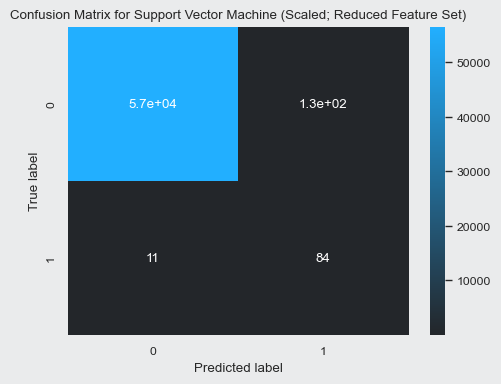

In [114]:
# Display the confusion matrix
confusion_matrix(y_true, svc_scaled_hpt_result.predictions, "Support Vector Machine (Scaled; Reduced Feature Set)")

In [115]:
_ = compare_models(svc_scaled_hpt_result, BEST_SCALED_HPT_15_RESULT)

-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = 0.005244 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.003049 --> Improvement!

Best model so far:
SVC(C=1.4, max_iter=15000, random_state=404, tol=0.0001) with Parameters
{'C': 1.4, 'degree': 3, 'kernel': 'rbf', 'tol': 0.0001}
Its score: 0.873469


In [116]:
best_svc_scaled = svc_scaled_model.best_estimator_
%time _ = best_svc_scaled.fit(X_train_scaled, y_train)

CPU times: user 59.8 ms, sys: 1.9 ms, total: 61.7 ms
Wall time: 21.9 ms


In [117]:
# Evaluate this model
svc_scaled_model_result = evaluate_model(
    model=best_svc_scaled,
    X_test=X_test_scaled,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE
)


-- Testing Results --
Accuracy    on Verification Data:	0.994343
Fbeta scroe on Verification Data:	0.857489

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56651
           1       0.21      0.88      0.34        95

    accuracy                           0.99     56746
   macro avg       0.61      0.94      0.67     56746
weighted avg       1.00      0.99      1.00     56746

False negatives: 11 (11.579% out of 95 true positives, 0.019% overall)



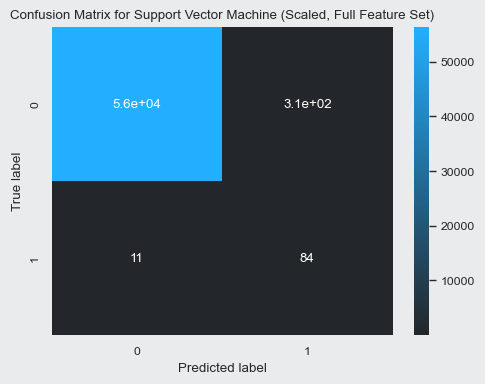

In [118]:
# Display the confusion matrix
confusion_matrix(y_true, svc_scaled_model_result.predictions, "Support Vector Machine (Scaled, Full Feature Set)")

In [119]:
_ = compare_models(svc_scaled_model_result, BEST_SCALED_HPT_RESULT)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.007672 --> Worsened!
new_results.accuracy - old_results.accuracy = 0.000476 --> Improvement!

Best model so far:
KNeighborsClassifier(n_jobs=-1, weights='distance')
Its score: 0.865162


In [120]:
# Check on learning progress when seeing the full feature set
_ = compare_models(svc_scaled_model_result, svc_scaled_hpt_result)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.015979 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.003190 --> Worsened!

Best model so far:
SVC(C=1.4, max_iter=15000, random_state=404, tol=0.0001)
Its score: 0.873469


In [214]:
BEST_MODEL, BEST_SCORE = compare_models(svc_scaled_model_result, results(top_overall(1)[0]))

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.007672 --> Worsened!
new_results.accuracy - old_results.accuracy = 0.000476 --> Improvement!

Best model so far:
KNeighborsClassifier(n_jobs=-1, weights='distance')
Its score: 0.865162


In [215]:
add_scaled_model("Support Vector Machine", svc_scaled_model_result)

--------------------------------------------------------------------------------

## Gradient Boost

In [123]:
from sklearn.ensemble import GradientBoostingClassifier

In [124]:
gradient_boost = GradientBoostingClassifier(random_state=404)                           # base estimator
gb_param_grid = {                                                                       # parameter grid for hyperparameter tuning
    'loss': ['log_loss', 'exponential'],
    'learning_rate': [.1, .5, 1., 1.5, 10.],
    'n_estimators': rf_param_grid['n_estimators'],
    'max_depth': rf_param_grid['max_depth'],
    'max_features': ['sqrt', 'log2'],
    'tol': lr_param_grid['tol'],
}

In [125]:
gb_model = GridSearchCV(
    estimator=gradient_boost,
    param_grid=gb_param_grid,
    refit=True,
    verbose=0,
    scoring=scorer
)

%time _ = gb_model.fit(X_train_15, y_train)

CPU times: user 18min 18s, sys: 6.09 s, total: 18min 24s
Wall time: 18min 43s


In [126]:
# Evaluate the process
gb_hpt_result = evaluate_hpt(
    model=gb_model,
    X_test=X_test_15,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE
)

-- Training Results --
Best Parameters:
	learning_rate:	10.0
	loss:	exponential
	max_depth:	5
	max_features:	sqrt
	n_estimators:	10
	tol:	0.0001
Best Score:
	0.892569

-- Testing Results --
Accuracy    on Verification Data:	0.883058
Fbeta scroe on Verification Data:	0.541906

              precision    recall  f1-score   support

           0       1.00      0.88      0.94     56651
           1       0.01      0.92      0.03        95

    accuracy                           0.88     56746
   macro avg       0.51      0.90      0.48     56746
weighted avg       1.00      0.88      0.94     56746

False negatives: 8 (8.421% out of 95 true positives, 0.014% overall)



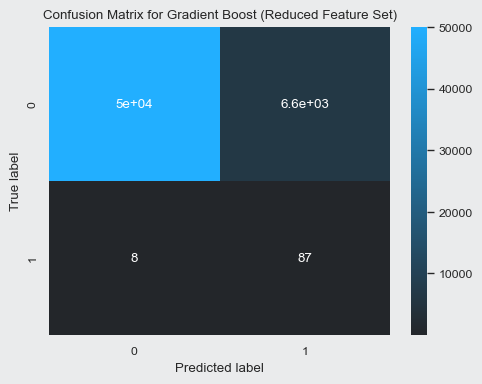

In [127]:
# Display the confusion matrix
confusion_matrix(y_true, gb_hpt_result.predictions, "Gradient Boost (Reduced Feature Set)")

In [128]:
# Compare HPT processes
_ = compare_models(gb_hpt_result, BEST_HPT_15_RESULT)

-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = -0.249840 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.099020 --> Worsened!

Best model so far:
GaussianNB() with Parameters
{'priors': None}
Its score: 0.791745


In [129]:
best_gb = gb_model.best_estimator_
%time _ = best_gb.fit(X_train, y_train)

CPU times: user 132 ms, sys: 1.81 ms, total: 134 ms
Wall time: 48 ms


In [130]:
# Evaluate this model
gb_model_result = evaluate_model(
    model=best_gb,
    X_test=X_test,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE
)


-- Testing Results --
Accuracy    on Verification Data:	0.724721
Fbeta scroe on Verification Data:	0.356650

              precision    recall  f1-score   support

           0       1.00      0.72      0.84     56651
           1       0.01      0.94      0.01        95

    accuracy                           0.72     56746
   macro avg       0.50      0.83      0.43     56746
weighted avg       1.00      0.72      0.84     56746

False negatives: 6 (6.316% out of 95 true positives, 0.011% overall)



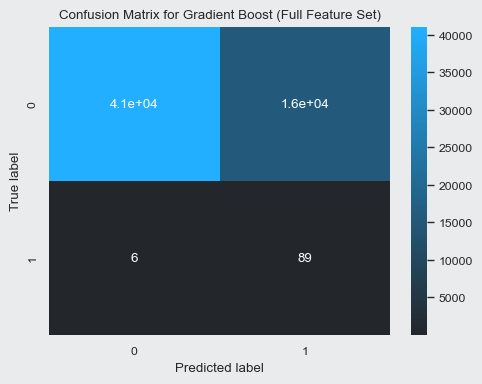

In [131]:
# Display the confusion matrix
confusion_matrix(y_true, gb_model_result.predictions, "Gradient Boost (Full Feature Set)")

In [132]:
# Check on learning progress when seeing the full feature set
_ = compare_models(gb_model_result, gb_hpt_result)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.185256 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.158337 --> Worsened!

Best model so far:
GradientBoostingClassifier(learning_rate=10.0, loss='exponential', max_depth=5,
                           max_features='sqrt', n_estimators=10,
                           random_state=404)
Its score: 0.541906


In [133]:
# Compare GB and RF on full feature set:
_ = compare_models(gb_model_result, BEST_HPT_RESULT)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.465747 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.260054 --> Worsened!

Best model so far:
RandomForestClassifier(max_depth=20, n_estimators=5, n_jobs=-1,
                       random_state=404)
Its score: 0.822397


In [216]:
# Store the model results
add_unscaled_model("Gradient Boost", gb_model_result)

BEST_MODEL, BEST_SCORE = compare_models(gb_model_result, results(top_overall(1)[0]))

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.508512 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.269147 --> Worsened!

Best model so far:
KNeighborsClassifier(n_jobs=-1, weights='distance')
Its score: 0.865162


In [135]:
# Repeat the process with the scaled dataset;
# Create a new grid search in order to avoid overwriting the original.
gb_scaled_model = GridSearchCV(
    estimator=gradient_boost,
    param_grid=gb_param_grid,
    refit=True,
    verbose=0,
    scoring=scorer
)
%time _ = gb_scaled_model.fit(X_train_scaled_15, y_train)

CPU times: user 18min 26s, sys: 4.27 s, total: 18min 30s
Wall time: 18min 40s


In [136]:
# Evaluate the process
gb_scaled_hpt_result = evaluate_hpt(
    model=gb_scaled_model,
    X_test=X_test_scaled_15,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE
)

-- Training Results --
Best Parameters:
	learning_rate:	10.0
	loss:	exponential
	max_depth:	5
	max_features:	sqrt
	n_estimators:	10
	tol:	0.0001
Best Score:
	0.892569

-- Testing Results --
Accuracy    on Verification Data:	0.883058
Fbeta scroe on Verification Data:	0.541906

              precision    recall  f1-score   support

           0       1.00      0.88      0.94     56651
           1       0.01      0.92      0.03        95

    accuracy                           0.88     56746
   macro avg       0.51      0.90      0.48     56746
weighted avg       1.00      0.88      0.94     56746

False negatives: 8 (8.421% out of 95 true positives, 0.014% overall)



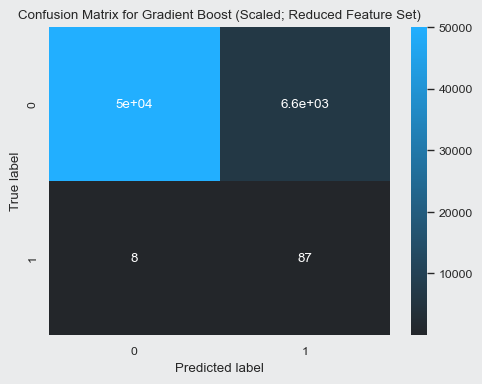

In [137]:
# Display the confusion matrix
confusion_matrix(y_true, gb_scaled_hpt_result.predictions, "Gradient Boost (Scaled; Reduced Feature Set)")

In [138]:
_ = compare_models(gb_scaled_hpt_result, BEST_SCALED_HPT_15_RESULT)

-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = -0.326318 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.111426 --> Worsened!

Best model so far:
KNeighborsClassifier(n_jobs=-1, weights='distance') with Parameters
{'n_neighbors': 5, 'weights': 'distance'}
Its score: 0.868224


In [139]:
best_gb_scaled = gb_scaled_model.best_estimator_
%time _ = best_gb_scaled.fit(X_train_scaled, y_train)

CPU times: user 140 ms, sys: 1.94 ms, total: 142 ms
Wall time: 47.4 ms


In [140]:
# Evaluate this model
gb_scaled_model_result = evaluate_model(
    model=best_gb_scaled,
    X_test=X_test_scaled,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE
)


-- Testing Results --
Accuracy    on Verification Data:	0.724721
Fbeta scroe on Verification Data:	0.356650

              precision    recall  f1-score   support

           0       1.00      0.72      0.84     56651
           1       0.01      0.94      0.01        95

    accuracy                           0.72     56746
   macro avg       0.50      0.83      0.43     56746
weighted avg       1.00      0.72      0.84     56746

False negatives: 6 (6.316% out of 95 true positives, 0.011% overall)



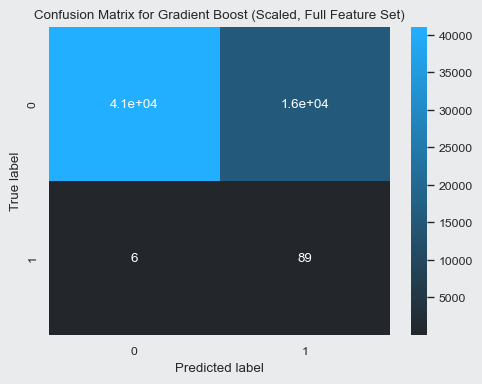

In [141]:
# Display the confusion matrix
confusion_matrix(y_true, gb_scaled_model_result.predictions, "Gradient Boost (Scaled, Full Feature Set)")

In [142]:
# Check on learning progress when seeing the full feature set
_ = compare_models(gb_scaled_model_result, gb_scaled_hpt_result)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.185256 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.158337 --> Worsened!

Best model so far:
GradientBoostingClassifier(learning_rate=10.0, loss='exponential', max_depth=5,
                           max_features='sqrt', n_estimators=10,
                           random_state=404)
Its score: 0.541906


In [143]:
_ = compare_models(gb_scaled_hpt_result, BEST_SCALED_HPT_RESULT)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.323256 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.110810 --> Worsened!

Best model so far:
KNeighborsClassifier(n_jobs=-1, weights='distance')
Its score: 0.865162


In [217]:
BEST_MODEL, BEST_SCORE = compare_models(gb_scaled_model_result, results(top_overall(1)[0]))

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.508512 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.269147 --> Worsened!

Best model so far:
KNeighborsClassifier(n_jobs=-1, weights='distance')
Its score: 0.865162


In [218]:
add_scaled_model("Gradient Boost", gb_scaled_model_result)

--------------------------------------------------------------------------------

## Ada Boost

In [146]:
from sklearn.ensemble import AdaBoostClassifier

In [147]:
ada_boost = AdaBoostClassifier(algorithm='SAMME', random_state=404)                     # base estimator
ab_param_grid = {                                                                       # parameter grid for hyperparameter tuning
    'learning_rate': gb_param_grid['learning_rate'],
    'n_estimators': gb_param_grid['n_estimators'],
}

In [148]:
ab_model = GridSearchCV(
    estimator=ada_boost,
    param_grid=ab_param_grid,
    refit=True,
    verbose=0,
    scoring=scorer
)

%time _ = ab_model.fit(X_train_15, y_train)

CPU times: user 17.8 s, sys: 105 ms, total: 17.9 s
Wall time: 17.6 s


In [149]:
# Evaluate the process
ab_hpt_result = evaluate_hpt(
    model=ab_model,
    X_test=X_test_15,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE
)

-- Training Results --
Best Parameters:
	learning_rate:	1.5
	n_estimators:	20
Best Score:
	0.873280

-- Testing Results --
Accuracy    on Verification Data:	0.975716
Fbeta scroe on Verification Data:	0.811023

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56651
           1       0.06      0.93      0.11        95

    accuracy                           0.98     56746
   macro avg       0.53      0.95      0.55     56746
weighted avg       1.00      0.98      0.99     56746

False negatives: 7 (7.368% out of 95 true positives, 0.012% overall)



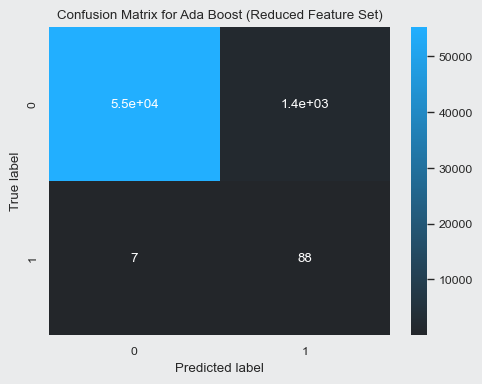

In [150]:
# Display the confusion matrix
confusion_matrix(y_true, ab_hpt_result.predictions, "Ada Boost (Reduced Feature Set)")

In [151]:
# Compare HPT processes
_ = compare_models(ab_hpt_result, BEST_HPT_15_RESULT)

-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = 0.019278 --> Improvement!
new_results.accuracy - old_results.accuracy = -0.006362 --> Worsened!

Best model so far:
AdaBoostClassifier(algorithm='SAMME', learning_rate=1.5, n_estimators=20,
                   random_state=404) with Parameters
{'learning_rate': 1.5, 'n_estimators': 20}
Its score: 0.811023


In [152]:
best_ab = ab_model.best_estimator_
%time _ = best_ab.fit(X_train, y_train)

CPU times: user 337 ms, sys: 3.89 ms, total: 341 ms
Wall time: 118 ms


In [153]:
# Evaluate this model
ab_model_result = evaluate_model(
    model=best_ab,
    X_test=X_test,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE
)


-- Testing Results --
Accuracy    on Verification Data:	0.968456
Fbeta scroe on Verification Data:	0.772891

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     56651
           1       0.05      0.92      0.09        95

    accuracy                           0.97     56746
   macro avg       0.52      0.94      0.54     56746
weighted avg       1.00      0.97      0.98     56746

False negatives: 8 (8.421% out of 95 true positives, 0.014% overall)



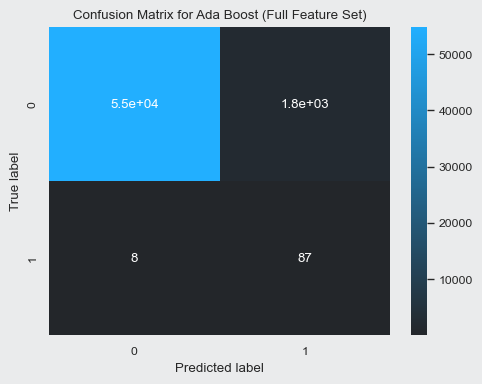

In [154]:
# Display the confusion matrix
confusion_matrix(y_true, ab_model_result.predictions, "Ada Boost (Full Feature Set)")

In [155]:
# Check on learning progress when seeing the full feature set
_ = compare_models(ab_model_result, ab_hpt_result)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.038132 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.007260 --> Worsened!

Best model so far:
AdaBoostClassifier(algorithm='SAMME', learning_rate=1.5, n_estimators=20,
                   random_state=404)
Its score: 0.811023


In [156]:
# Compare AB and RF on full feature set:
_ = compare_models(ab_model_result, BEST_HPT_RESULT)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.049506 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.016318 --> Worsened!

Best model so far:
RandomForestClassifier(max_depth=20, n_estimators=5, n_jobs=-1,
                       random_state=404)
Its score: 0.822397


In [219]:
# Store the model results
add_unscaled_model("Ada Boost", ab_model_result)

BEST_MODEL, BEST_SCORE = compare_models(ab_model_result, results(top_overall(1)[0]))

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.092271 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.025411 --> Worsened!

Best model so far:
KNeighborsClassifier(n_jobs=-1, weights='distance')
Its score: 0.865162


In [158]:
# Repeat the process with the scaled dataset;
# Create a new grid search in order to avoid overwriting the original.
ab_scaled_model = GridSearchCV(
    estimator=ada_boost,
    param_grid=ab_param_grid,
    refit=True,
    verbose=0,
    scoring=scorer
)
%time _ = ab_scaled_model.fit(X_train_scaled_15, y_train)

CPU times: user 17.9 s, sys: 108 ms, total: 18 s
Wall time: 18 s


In [159]:
# Evaluate the process
ab_scaled_hpt_result = evaluate_hpt(
    model=ab_scaled_model,
    X_test=X_test_scaled_15,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE
)

-- Training Results --
Best Parameters:
	learning_rate:	1.5
	n_estimators:	20
Best Score:
	0.873280

-- Testing Results --
Accuracy    on Verification Data:	0.975716
Fbeta scroe on Verification Data:	0.811023

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56651
           1       0.06      0.93      0.11        95

    accuracy                           0.98     56746
   macro avg       0.53      0.95      0.55     56746
weighted avg       1.00      0.98      0.99     56746

False negatives: 7 (7.368% out of 95 true positives, 0.012% overall)



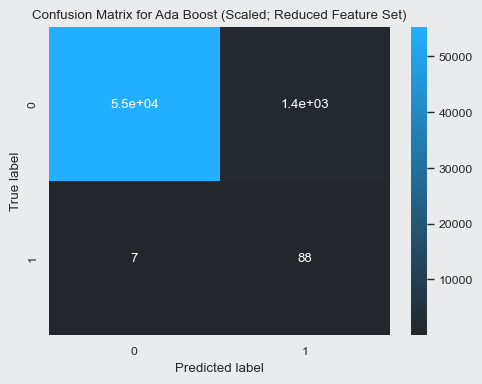

In [160]:
# Display the confusion matrix
confusion_matrix(y_true, ab_scaled_hpt_result.predictions, "Ada Boost (Scaled; Reduced Feature Set)")

In [161]:
_ = compare_models(ab_scaled_hpt_result, BEST_SCALED_HPT_15_RESULT)

-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = -0.057201 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.018768 --> Worsened!

Best model so far:
KNeighborsClassifier(n_jobs=-1, weights='distance') with Parameters
{'n_neighbors': 5, 'weights': 'distance'}
Its score: 0.868224


In [162]:
best_ab_scaled = ab_scaled_model.best_estimator_
%time _ = best_ab_scaled.fit(X_train_scaled, y_train)

CPU times: user 332 ms, sys: 3.53 ms, total: 336 ms
Wall time: 117 ms


In [163]:
# Evaluate this model
ab_scaled_model_result = evaluate_model(
    model=best_ab_scaled,
    X_test=X_test_scaled,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE
)


-- Testing Results --
Accuracy    on Verification Data:	0.968456
Fbeta scroe on Verification Data:	0.772891

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     56651
           1       0.05      0.92      0.09        95

    accuracy                           0.97     56746
   macro avg       0.52      0.94      0.54     56746
weighted avg       1.00      0.97      0.98     56746

False negatives: 8 (8.421% out of 95 true positives, 0.014% overall)



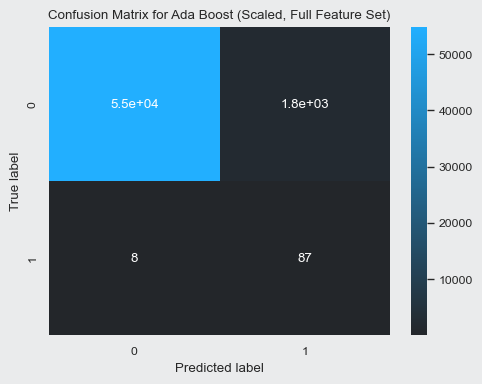

In [164]:
# Display the confusion matrix
confusion_matrix(y_true, ab_scaled_model_result.predictions, "Ada Boost (Scaled, Full Feature Set)")

In [165]:
# Check on learning progress when seeing the full feature set
_ = compare_models(ab_scaled_model_result, ab_scaled_hpt_result)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.038132 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.007260 --> Worsened!

Best model so far:
AdaBoostClassifier(algorithm='SAMME', learning_rate=1.5, n_estimators=20,
                   random_state=404)
Its score: 0.811023


In [166]:
_ = compare_models(ab_scaled_hpt_result, BEST_SCALED_HPT_RESULT)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.054139 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.018151 --> Worsened!

Best model so far:
KNeighborsClassifier(n_jobs=-1, weights='distance')
Its score: 0.865162


In [220]:
BEST_MODEL, BEST_SCORE = compare_models(ab_scaled_model_result, results(top_overall(1)[0]))

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.092271 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.025411 --> Worsened!

Best model so far:
KNeighborsClassifier(n_jobs=-1, weights='distance')
Its score: 0.865162


In [221]:
add_scaled_model("Ada Boost", ab_scaled_model_result)

--------------------------------------------------------------------------------

## Artificial Neural Network

In [169]:
from sklearn.neural_network import MLPClassifier

In [170]:
neural_network = MLPClassifier(                                                             # base estimator
    solver='adam',
    learning_rate='constant',
    early_stopping=True,
    random_state=404
)
nn_param_grid = {                                                                           # parameter grid for hyperparameter tuning
    'hidden_layer_sizes': [(128,), (128, 128), (64, 64, 32), (124, 64, 32), (64, 64, 64, 32), (64, 32, 16)],
    'activation': ['relu', 'logistic', 'tanh'],
    'alpha': [1.e-4, 1.e-3, 1.e-2],
    'learning_rate_init': ab_param_grid['learning_rate'],
    'tol': gb_param_grid['tol'],
}

In [171]:
nn_model = GridSearchCV(
    estimator=neural_network,
    param_grid=nn_param_grid,
    refit=True,
    verbose=0,
    scoring=scorer
)

%time _ = nn_model.fit(X_train_15, y_train)

CPU times: user 2h 10min, sys: 1min 27s, total: 2h 11min 28s
Wall time: 18min 14s


In [172]:
# Evaluate the process
nn_hpt_result = evaluate_hpt(
    model=nn_model,
    X_test=X_test_15,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE
)

-- Training Results --
Best Parameters:
	activation:	relu
	alpha:	0.01
	hidden_layer_sizes:	(128,)
	learning_rate_init:	1.5
	tol:	0.0001
Best Score:
	0.889372

-- Testing Results --
Accuracy    on Verification Data:	0.953935
Fbeta scroe on Verification Data:	0.745143

              precision    recall  f1-score   support

           0       1.00      0.95      0.98     56651
           1       0.03      0.95      0.06        95

    accuracy                           0.95     56746
   macro avg       0.52      0.95      0.52     56746
weighted avg       1.00      0.95      0.97     56746

False negatives: 5 (5.263% out of 95 true positives, 0.009% overall)



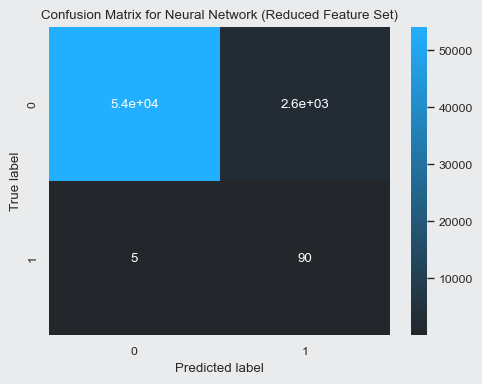

In [173]:
# Display the confusion matrix
confusion_matrix(y_true, nn_hpt_result.predictions, "Neural Network (Reduced Feature Set)")

In [174]:
# Compare HPT processes
_ = compare_models(nn_hpt_result, BEST_HPT_15_RESULT)

-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = -0.046602 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.028143 --> Worsened!

Best model so far:
GaussianNB() with Parameters
{'priors': None}
Its score: 0.791745


In [175]:
best_nn = nn_model.best_estimator_
%time _ = best_nn.fit(X_train, y_train)

CPU times: user 931 ms, sys: 9.91 ms, total: 941 ms
Wall time: 130 ms


In [176]:
# Evaluate this model
nn_model_result = evaluate_model(
    model=best_nn,
    X_test=X_test,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE
)


-- Testing Results --
Accuracy    on Verification Data:	0.986219
Fbeta scroe on Verification Data:	0.819314

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56651
           1       0.10      0.88      0.18        95

    accuracy                           0.99     56746
   macro avg       0.55      0.94      0.58     56746
weighted avg       1.00      0.99      0.99     56746

False negatives: 11 (11.579% out of 95 true positives, 0.019% overall)



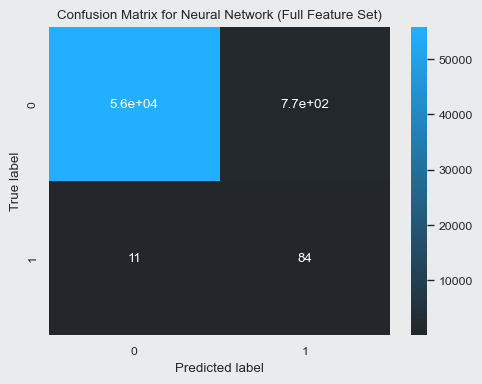

In [177]:
# Display the confusion matrix
confusion_matrix(y_true, nn_model_result.predictions, "Neural Network (Full Feature Set)")

In [178]:
# Check on learning progress when seeing the full feature set
_ = compare_models(nn_model_result, nn_hpt_result)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.074171 --> Improvement!
new_results.accuracy - old_results.accuracy = 0.032284 --> Improvement!

Best model so far:
MLPClassifier(alpha=0.01, early_stopping=True, hidden_layer_sizes=(128,),
              learning_rate_init=1.5, random_state=404)
Its score: 0.819314


In [179]:
# Compare AB and RF on full feature set:
_ = compare_models(nn_model_result, BEST_HPT_RESULT)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.003082 --> Worsened!
new_results.accuracy - old_results.accuracy = 0.001445 --> Improvement!

Best model so far:
RandomForestClassifier(max_depth=20, n_estimators=5, n_jobs=-1,
                       random_state=404)
Its score: 0.822397


In [222]:
# Store the model results
add_unscaled_model("Neural Network", nn_model_result)

BEST_MODEL, BEST_SCORE = compare_models(nn_model_result, results(top_overall(1)[0]))

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.045847 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.007648 --> Worsened!

Best model so far:
KNeighborsClassifier(n_jobs=-1, weights='distance')
Its score: 0.865162


In [181]:
# Repeat the process with the scaled dataset;
# Create a new grid search in order to avoid overwriting the original.
nn_scaled_model = GridSearchCV(
    estimator=neural_network,
    param_grid=nn_param_grid,
    refit=True,
    verbose=0,
    scoring=scorer
)
%time _ = nn_scaled_model.fit(X_train_scaled_15, y_train)

CPU times: user 2h 11min 41s, sys: 1min 19s, total: 2h 13min
Wall time: 18min 30s


In [182]:
# Evaluate the process
nn_scaled_hpt_result = evaluate_hpt(
    model=nn_scaled_model,
    X_test=X_test_scaled_15,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE
)

-- Training Results --
Best Parameters:
	activation:	logistic
	alpha:	0.0001
	hidden_layer_sizes:	(64, 32, 16)
	learning_rate_init:	0.1
	tol:	0.0001
Best Score:
	0.886557

-- Testing Results --
Accuracy    on Verification Data:	0.992792
Fbeta scroe on Verification Data:	0.879756

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56651
           1       0.18      0.92      0.30        95

    accuracy                           0.99     56746
   macro avg       0.59      0.95      0.65     56746
weighted avg       1.00      0.99      1.00     56746

False negatives: 8 (8.421% out of 95 true positives, 0.014% overall)



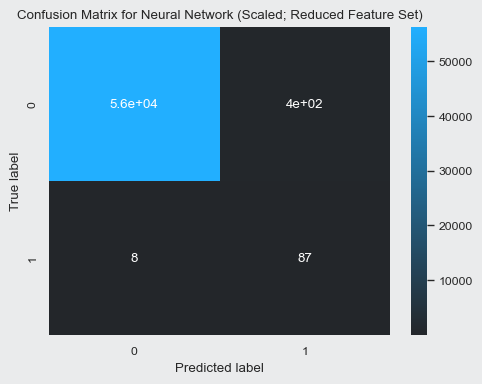

In [183]:
# Display the confusion matrix
confusion_matrix(y_true, nn_scaled_hpt_result.predictions, "Neural Network (Scaled; Reduced Feature Set)")

In [184]:
_ = compare_models(nn_scaled_hpt_result, BEST_SCALED_HPT_15_RESULT)

-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = 0.011532 --> Improvement!
new_results.accuracy - old_results.accuracy = -0.001692 --> Worsened!

Best model so far:
MLPClassifier(activation='logistic', early_stopping=True,
              hidden_layer_sizes=(64, 32, 16), learning_rate_init=0.1,
              random_state=404) with Parameters
{'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': (64, 32, 16), 'learning_rate_init': 0.1, 'tol': 0.0001}
Its score: 0.879756


In [185]:
best_nn_scaled = nn_scaled_model.best_estimator_
%time _ = best_nn_scaled.fit(X_train_scaled, y_train)

CPU times: user 934 ms, sys: 12.5 ms, total: 947 ms
Wall time: 131 ms


In [186]:
# Evaluate this model
nn_scaled_model_result = evaluate_model(
    model=best_nn_scaled,
    X_test=X_test_scaled,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE
)


-- Testing Results --
Accuracy    on Verification Data:	0.998326
Fbeta scroe on Verification Data:	0.000000

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.00      0.00      0.00        95

    accuracy                           1.00     56746
   macro avg       0.50      0.50      0.50     56746
weighted avg       1.00      1.00      1.00     56746

False negatives: 95 (100.000% out of 95 true positives, 0.167% overall)



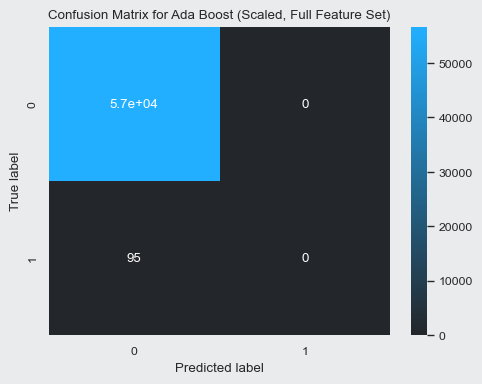

In [187]:
# Display the confusion matrix
confusion_matrix(y_true, nn_scaled_model_result.predictions, "Ada Boost (Scaled, Full Feature Set)")

In [188]:
# Check on learning progress when seeing the full feature set
_ = compare_models(nn_scaled_model_result, nn_scaled_hpt_result)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.879756 --> Worsened!
new_results.accuracy - old_results.accuracy = 0.005533 --> Improvement!

Best model so far:
MLPClassifier(activation='logistic', early_stopping=True,
              hidden_layer_sizes=(64, 32, 16), learning_rate_init=0.1,
              random_state=404)
Its score: 0.879756


In [189]:
_ = compare_models(nn_scaled_hpt_result, BEST_SCALED_HPT_RESULT)

-- Model Comparison --
new_results.fbeta - old_results.fbeta = 0.014594 --> Improvement!
new_results.accuracy - old_results.accuracy = -0.001075 --> Worsened!

Best model so far:
MLPClassifier(activation='logistic', early_stopping=True,
              hidden_layer_sizes=(64, 32, 16), learning_rate_init=0.1,
              random_state=404)
Its score: 0.879756


In [223]:
BEST_MODEL, BEST_SCORE = compare_models(nn_scaled_model_result, results(top_overall(1)[0]))

-- Model Comparison --
new_results.fbeta - old_results.fbeta = -0.865162 --> Worsened!
new_results.accuracy - old_results.accuracy = 0.004458 --> Improvement!

Best model so far:
KNeighborsClassifier(n_jobs=-1, weights='distance')
Its score: 0.865162


In [224]:
add_scaled_model("Neural Network", nn_scaled_model_result)

--------------------------------------------------------------------------------

## Voting Classification

First, let's have a look at our best models.

In [238]:
num_models = 4
best_scaled_models = top_scaled(num_models)         # top n models on scaled data
best_unscaled_models = top_unscaled(num_models)     # top n models on unscaled data

# For confirmation, print the top n for the scaled case:
list(map(name, best_scaled_models))

['K Nearest Neighbours',
 'Support Vector Machine',
 'Random Forest',
 'Ada Boost']

In [239]:
list(map(name, best_unscaled_models))

['Logistic Regression', 'Random Forest', 'Neural Network', 'Ada Boost']

Unfortunately, `SVC` doesn't support probability prediction, so it can't be used in the `VotingClassifier`.
We need to remove it from our list of best models, if it is contained...

In [240]:
best_scaled_models = list(top_scaled(num_models+1) | where (lambda model: "Support Vector" not in name(model)))[:num_models]
best_unscaled_models = list(top_unscaled(num_models+1) | where (lambda model: "Support Vector" not in name(model)))[:num_models]

In [241]:
list(map(name, best_scaled_models))

['K Nearest Neighbours', 'Random Forest', 'Ada Boost', 'Naive Bayes']

In [242]:
list(map(name, best_unscaled_models))

['Logistic Regression', 'Random Forest', 'Neural Network', 'Ada Boost']

In [243]:
from sklearn.ensemble import VotingClassifier

In [244]:
# Construct the voting classifier with the best models
def make_voting_classifier(models):
    return VotingClassifier(
        list(
            map(
                lambda model: (name(model), results(model).model),
                models
            )
        ),
        voting='soft',
        n_jobs=-1
    )
compound_unscaled = make_voting_classifier(best_unscaled_models)
compound_scaled = make_voting_classifier(best_scaled_models)

In [245]:
# Train the classifiers

%time _ = compound_unscaled.fit(X_train, y_train)

CPU times: user 8.69 ms, sys: 8.97 ms, total: 17.7 ms
Wall time: 891 ms


In [246]:
%time _ = compound_scaled.fit(X_train_scaled, y_train)

CPU times: user 5.72 ms, sys: 4.27 ms, total: 9.99 ms
Wall time: 637 ms


In [247]:
# Evaluate the result
compound_unscaled_result = evaluate_model(
    model=compound_unscaled,
    X_test=X_test,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE
)


-- Testing Results --
Accuracy    on Verification Data:	0.992546
Fbeta scroe on Verification Data:	0.858672

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56651
           1       0.17      0.89      0.29        95

    accuracy                           0.99     56746
   macro avg       0.59      0.94      0.64     56746
weighted avg       1.00      0.99      1.00     56746

False negatives: 10 (10.526% out of 95 true positives, 0.018% overall)



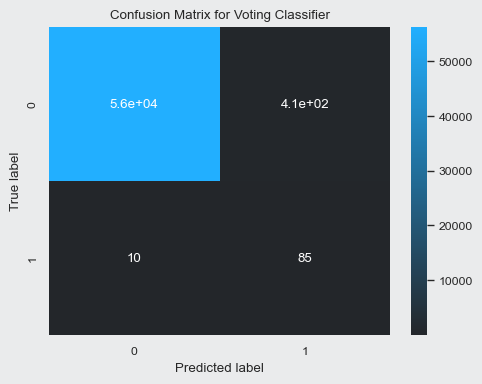

In [248]:
# Display the confusion matrix
confusion_matrix(y_true, compound_unscaled_result.predictions, "Voting Classifier")

In [249]:
# Evaluate the result (on scaled data)
compound_scaled_result = evaluate_model(
    model=compound_scaled,
    X_test=X_test_scaled,
    y_true=y_true,
    beta=BETA,
    average=AVERAGE
)


-- Testing Results --
Accuracy    on Verification Data:	0.988545
Fbeta scroe on Verification Data:	0.829893

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56651
           1       0.12      0.88      0.21        95

    accuracy                           0.99     56746
   macro avg       0.56      0.94      0.60     56746
weighted avg       1.00      0.99      0.99     56746

False negatives: 11 (11.579% out of 95 true positives, 0.019% overall)



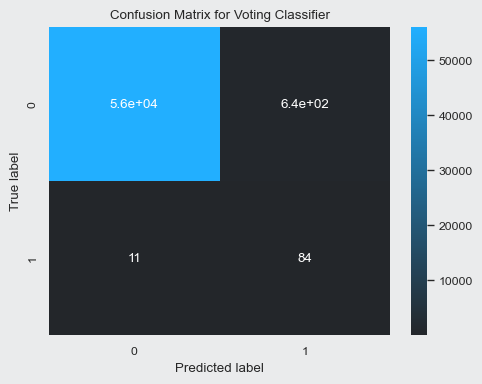

In [250]:
# Display the confusion matrix
confusion_matrix(y_true, compound_scaled_result.predictions, "Voting Classifier")

--------------------------------------------------------------------------------

To next notebook: [Network Traffic EDA](./network-traffic-eda.ipynb)